In [1]:
import os, sys
import numpy as np
import keras.layers
import h5py
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# local imports.

sys.path.append('/home/maria/Documents/')
sys.path.append('/home/maria/Documents/voxelmorph/')
#sys.path.append('/home/maria/Documents/neuron/')
sys.path.append('/home/maria/Documents/voxelmorph/ext/pynd-lib/')
sys.path.append('/home/maria/Documents/voxelmorph/ext/pytools-lib/')
sys.path.append('/home/maria/Documents/voxelmorph/ext/neuron/')
#sys.path.append('/kaggle/input/voxelmorph/voxelmorph/')
#sys.path.append('/kaggle/input/voxelmorph/voxelmorph/ext/neuron/')
#sys.path.append('/kaggle/input/voxelmorph/voxelmorph/')
#import voxelmorph as vxm
import neuron
import voxelmorph as vxm
import voxelmorph.src.networks as mdl

In [3]:
image = np.array(h5py.File('/media/maria/DATA1/Documents/Downl/fish04_6dpf_amph_std_dev.h5', 'r')['ITKImage']['0']['VoxelData'])

In [4]:
print(image.shape)

(21, 1024, 1024)


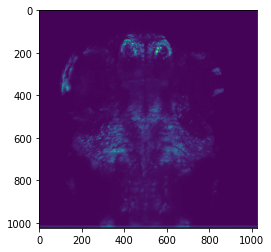

In [5]:
plt.imshow(image[10,:,:])

In [6]:
im_to_warp=image[10,:,:]
print(im_to_warp.shape)

(1024, 1024)


# Affine transformations of image usin skimage

In [7]:
from skimage.transform import warp, AffineTransform
from skimage.transform import resize


In [8]:
random_rots=np.random.uniform(0.1,1.0,100)
random_shear=np.random.uniform(0.0,0.5,100)

In [9]:
print(random_rots)
print(random_shear)

[0.96719577 0.30061286 0.52640491 0.25289238 0.37142279 0.87204908
 0.97906367 0.33025813 0.50204772 0.34051194 0.78430959 0.44957725
 0.61683427 0.85767935 0.97527698 0.37864341 0.11255042 0.7695159
 0.29197462 0.2424621  0.52343147 0.60760794 0.61307642 0.98975186
 0.16303826 0.26677272 0.85048001 0.16358469 0.69763889 0.11065255
 0.16680424 0.46286687 0.57493911 0.48136111 0.61569285 0.33460569
 0.98232343 0.27790343 0.40403455 0.32783276 0.6957108  0.18230281
 0.24569418 0.17116232 0.61665224 0.29951513 0.8526469  0.96166289
 0.47386236 0.57102647 0.83920748 0.50897488 0.21673674 0.717589
 0.33169056 0.25537385 0.34333908 0.65359462 0.29902955 0.26430259
 0.5773108  0.72211426 0.67107601 0.62393444 0.20770783 0.77022675
 0.77029797 0.51556717 0.71824974 0.69415221 0.42190312 0.74982099
 0.76402567 0.76392036 0.61163119 0.97668659 0.57882303 0.15202517
 0.19666685 0.38519282 0.5228716  0.42214851 0.50211786 0.53881225
 0.30884246 0.51608218 0.39596199 0.15312207 0.94953458 0.2258234

In [10]:
im_lst=[]
for ind in range(0,10):
    tform = AffineTransform(rotation=random_rots[ind], shear=random_shear[ind])
    image = warp(im_to_warp, tform.inverse)
    image = resize(image, (32,32),anti_aliasing=True)
    im_lst.append(image)
    

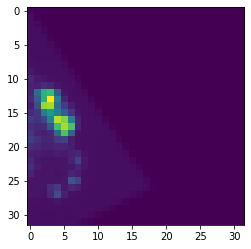

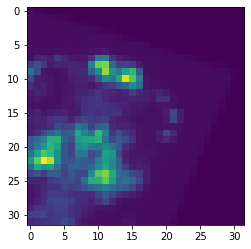

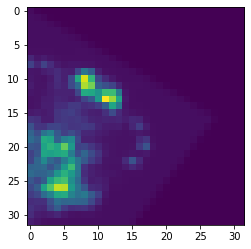

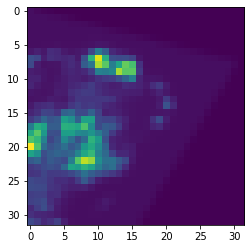

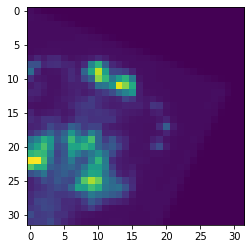

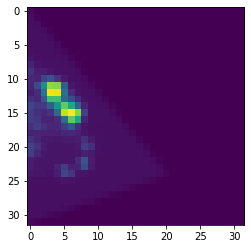

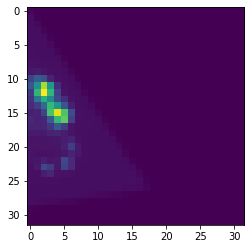

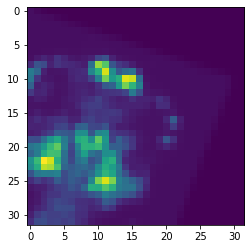

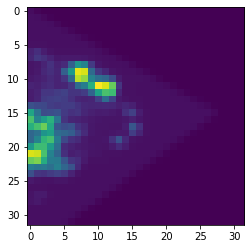

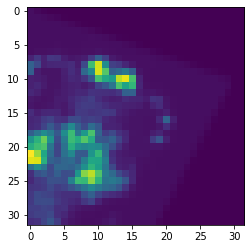

In [11]:
for im in im_lst:
    plt.imshow(im)
    plt.show()

In [12]:
im_lst_val=[]
for ind in range(0,10):
    tform = AffineTransform(rotation=random_rots[ind], shear=random_shear[ind])
    image = warp(im_to_warp, tform.inverse)
    image = resize(image, (32,32),anti_aliasing=True)
    im_lst_val.append(image)
    
im_lst_val=np.array(im_lst_val)

# Train voxelmorph

In [20]:
def vxm_data_generator(x_data, batch_size=32):
    """
    generator that takes in data of size [N, H, W], and yields data for our vxm model
    
    Note that we need to provide numpy data for each input, and each output
    
    inputs:  moving_image [bs, H, W, 1], fixed_image [bs, H, W, 1]
    outputs: moved_image  [bs, H, W, 1], zeros [bs, H, W, 2]
    """
    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation. We'll explain this below.
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs
        # inputs need to be of the size [batch_size, H, W, number_features]
        #   number_features at input is 1 for us
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        idx2=np.array([0]*batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # outputs
        # we need to prepare the "true" moved image.  
        # Of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield inputs, outputs  

In [21]:
ndims = 2
vol_shape = np.array(im_lst).shape[1:]
nb_enc_features = [32, 32, 32, 32]
nb_dec_features = [32, 32, 32, 32, 32, 16]
unet = mdl.unet_core(vol_shape, nb_enc_features, nb_dec_features)
# inputs
print('numer of inputs', len(unet.inputs))
moving_input_tensor = unet.inputs[0]
fixed_input_tensor = unet.inputs[1]
    
# output
print('output:', unet.output)

# transform the results into a flow field.
disp_tensor = keras.layers.Conv2D(ndims, kernel_size=3, padding='same', name='disp')(unet.output)

# check
print('displacement tensor:', disp_tensor)

# a cool aspect of keras is that we can easily form new models via tensor pointers:
def_model = keras.models.Model(unet.inputs, disp_tensor)
# def_model will now *share layers* with the UNet -- if we change layer weights 
# in the UNet, they change in the def_model

spatial_transformer = neuron.layers.SpatialTransformer(name='spatial_transformer')

# warp the image
moved_image_tensor = spatial_transformer([moving_input_tensor, disp_tensor])

numer of inputs 2
output: Tensor("leaky_re_lu_20/LeakyRelu:0", shape=(None, 32, 32, 16), dtype=float32)
displacement tensor: Tensor("disp_1/BiasAdd:0", shape=(None, 32, 32, 2), dtype=float32)


In [22]:
inputs = [moving_input_tensor, fixed_input_tensor]
outputs = [moved_image_tensor, disp_tensor]
vxm_model = keras.models.Model(inputs, outputs)

In [23]:
# losses. Keras recognizes the string 'mse' as mean squared error, so we don't have to code it
losses = ['mse', mdl.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter.
lambda_param = 0.05
loss_weights = [1, lambda_param]


In [24]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

In [18]:
help(vxm)

Help on package voxelmorph:

NAME
    voxelmorph

PACKAGE CONTENTS
    src (package)

FILE
    /home/maria/Documents/voxelmorph/__init__.py




In [25]:
# let's test it
train_generator = vxm_data_generator(np.array(im_lst))

nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/10
 - 17s - loss: 135.6454 - spatial_transformer_loss: 133.3033 - disp_loss: 46.8438
Epoch 2/10
 - 15s - loss: 110.5568 - spatial_transformer_loss: 109.4407 - disp_loss: 22.3205
Epoch 3/10
 - 16s - loss: 85.7362 - spatial_transformer_loss: 84.8089 - disp_loss: 18.5456
Epoch 4/10
 - 17s - loss: 43.4914 - spatial_transformer_loss: 43.0735 - disp_loss: 8.3593
Epoch 5/10
 - 16s - loss: 31.0991 - spatial_transformer_loss: 30.8028 - disp_loss: 5.9259
Epoch 6/10
 - 19s - loss: 27.7627 - spatial_transformer_loss: 27.4823 - disp_loss: 5.6090
Epoch 7/10
 - 18s - loss: 27.4807 - spatial_transformer_loss: 27.2204 - disp_loss: 5.2065
Epoch 8/10
 - 22s - loss: 26.3382 - spatial_transformer_loss: 26.0913 - disp_loss: 4.9365
Epoch 9/10
 - 18s - loss: 25.7763 - spatial_transformer_loss: 25.5381 - disp_loss: 4.7647
Epoch 10/10
 - 19s - loss: 26.1968 - spatial_transformer_loss: 25.9705 - disp_loss: 4.5266


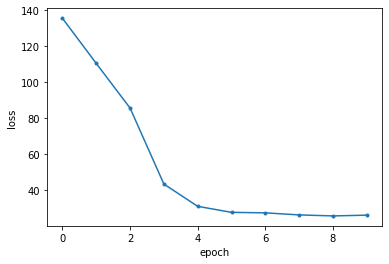

In [26]:
# as with other imports, this import should be at the top, or use notebook matplotlib magic
# we keep it here to be explicit why we need it
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    """
    Quick function to plot the history 
    """
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

In [27]:
val_generator = vxm_data_generator(np.array(im_lst_val), batch_size = 1)
val_input, _ = next(val_generator)

In [28]:
val_pred = vxm_model.predict(val_input)

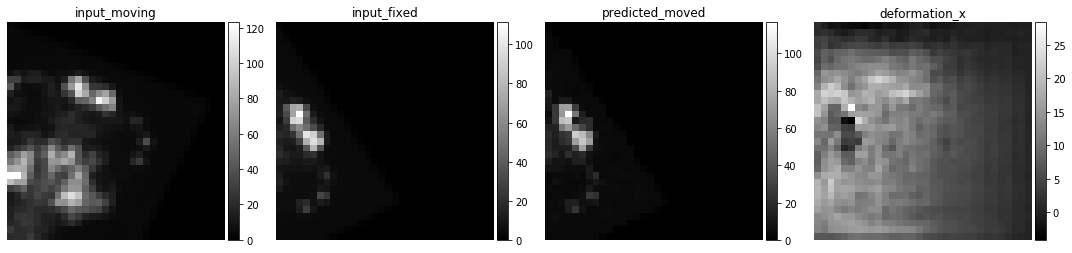

In [29]:
# visualize
slices_2d = [f[0,...,0] for f in val_input + val_pred]
titles = ['input_moving', 'input_fixed', 'predicted_moved', 'deformation_x']
neuron.plot.slices(slices_2d, titles=titles, cmaps=['gray'], do_colorbars=True);

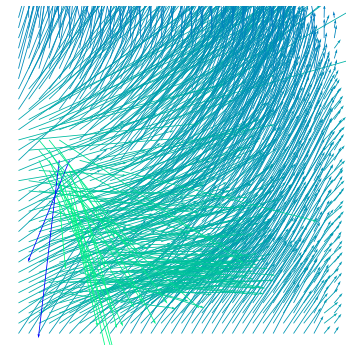

In [30]:
neuron.plot.flow([val_pred[1].squeeze()], width=5);